# Part 1: Data Exploration and Model Building (55 Marks)

In [1]:
!pip install rouge-score

  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c7d242e0ee042c0cd7782797d98809827a60a5cb82323e3fe2ee5c479bef5d33
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


## I. Importing Libraries and Data

In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
import sys
from contextlib import redirect_stdout
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Concatenate, Dense, TimeDistributed, LSTM, Bidirectional, Embedding, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from keras.utils import plot_model

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Datasets library
import datasets
from datasets import load_dataset
from rouge_score import rouge_scorer

import re
import string
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset with predefined splits
df = load_dataset("abisee/cnn_dailymail", "3.0.0")
# Convert dataset splits to DataFrames and drop 'id' column in one step
train_df = pd.DataFrame.from_dict(df['train']).drop(columns='id').reset_index(drop=True)
valid_df = pd.DataFrame.from_dict(df['validation']).drop(columns='id').reset_index(drop=True)
test_df = pd.DataFrame.from_dict(df['test']).drop(columns='id').reset_index(drop=True)

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
train_df.head()

,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


## II. Data Preprocessing

In [5]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", 
    "could've": "could have", "couldn't": "could not", "didn't": "did not", 
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", 
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", 
    "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it would", "it'll": "it will", 
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have", "mightn't": "might not", "must've": "must have", 
    "mustn't": "must not", "needn't": "need not", "o'clock": "of the clock", 
    "oughtn't": "ought not", "shan't": "shall not", "she'd": "she would", "she'll": "she will", 
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "so's": "so as",
    "that'd": "that would", "that's": "that is", "there'd": "there would", "there's": "there is", 
    "they'd": "they would", "they'll": "they will", "they're": "they are", "they've": "they have", 
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'll": "we will", 
    "we're": "we are", "we've": "we have", "weren't": "were not", "what's": "what is", 
    "what're": "what are", "where's": "where is", "who's": "who is", "why's": "why is", 
    "will've": "will have", "won't": "will not", "would've": "would have", 
    "wouldn't": "would not", "y'all": "you all", "you're": "you are"
}

In [6]:
# Additional mappings for lowercase variants
lowercase_mappings = {key.lower(): value for key, value in contraction_mapping.items()}
contraction_mapping.update(lowercase_mappings)

In [7]:
class TextPreprocessor:
    def __init__(self, contraction_mapping=None):
        """
        Initialize the TextPreprocessor class with necessary variables like stopwords 
        and contraction mappings.
        """
        self.stopwords = set(stopwords.words('english'))  # Set of stopwords from NLTK
        self.contraction_mapping = contraction_mapping if contraction_mapping else {}  # Contraction mappings

    def preprocess(self, text):
        """
        Main function to preprocess a given text. This includes:
        - Lowercasing
        - Removing special characters and punctuations
        - Replacing contractions
        - Removing stopwords
        - Removing short words
        """
        # Lowercasing the text
        new_text = text.lower()

        # Removing text inside parentheses
        new_text = re.sub(r'\([^)]*\)', '', new_text)

        # Removing double quotes
        new_text = re.sub('"', '', new_text)

        # Replacing contractions using contraction mapping
        new_text = ' '.join([self.contraction_mapping[t] if t in self.contraction_mapping else t for t in new_text.split(" ")])

        # Eliminating apostrophes
        new_text = re.sub(r"'s\b", "", new_text)

        # Removing non-alphabetical characters
        new_text = re.sub("[^a-zA-Z]", " ", new_text)

        # Removing stopwords
        new_text = ' '.join([word for word in new_text.split() if word not in self.stopwords])

        # Removing very short words (less than 3 characters)
        new_text = ' '.join([word for word in new_text.split() if len(word) >= 3])

        return new_text

    def preprocess_dataset(self, df):
        """
        Apply preprocessing to both 'article' and 'highlights' columns in the DataFrame.
        """
        text_cleaned = []
        summ_cleaned = []
        max_len_text = 0
        max_len_sum = 0
        
        # Preprocess articles (text)
        for text in df['article']:
            t = self.preprocess(text)
            max_len_text += len(t.split())
            text_cleaned.append(t)
        max_len_text /= (5.0 * len(df['article']))
        
        # Preprocess highlights (summaries)
        for summary in df['highlights']:
            s = self.preprocess(summary)
            max_len_sum += len(s.split()) 
            summ_cleaned.append(s)
        max_len_sum /= (5.0 * len(df['highlights']))
        
        # Create a new DataFrame with cleaned data
        clean_df = pd.DataFrame()
        clean_df['article'] = text_cleaned
        clean_df['highlights'] = summ_cleaned

        # Replace empty summaries with NaN and drop those rows
        clean_df['highlights'] = clean_df['highlights'].replace('', np.nan)
        clean_df = clean_df.dropna(axis=0)

        # Add START and END tokens to the highlights (for future use in model training)
        clean_df['highlights'] = clean_df['highlights'].apply(lambda x: '<START> ' + x + ' <END>')

        return clean_df, int(max_len_text), int(max_len_sum)

    def display_samples(self, df, num_samples=5):
        """
        Display the first few cleaned samples from the DataFrame with proper formatting.
        The 'News' and 'Summary' headers will be printed in bold.
        """
        for i in range(min(num_samples, len(df))):
            # Bold formatting for headers
            print('\033[1m' + 'News:' + '\033[0m', df['article'][i], '\n')
            print('\033[1m' + 'Summary:' + '\033[0m', df['highlights'][i], '\n\n')

In [8]:
# Create an instance of the TextPreprocessor class with the contraction mapping
preprocessor = TextPreprocessor(contraction_mapping)
# Preprocess the dataset
clean_df_train, max_len_news, max_len_headline = preprocessor.preprocess_dataset(train_df)
# Display the first 5 records with proper formatting
preprocessor.display_samples(clean_df_train, num_samples=2)

News: london england harry potter star daniel radcliffe gains access reported million fortune turns monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties plan one people soon turn suddenly buy massive sports car collection something similar told australian interviewer earlier month think particularly extravagant things like buying things cost pounds books cds dvds radcliffe able gamble casino buy drink pub see horror film hostel part currently six places number one movie box office chart details mark landmark birthday wraps agent publicist comment plans definitely sort party said interview hopefully none reading radcliffe earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking say kid star goes rails told reporters last month try hard way wou

In [9]:
# Preprocess the dataset
clean_df_valid, _, _ = preprocessor.preprocess_dataset(valid_df)
# Display the first 5 records with proper formatting
preprocessor.display_samples(clean_df_valid, num_samples=2)

News: share gift multiplied may sound like esoteric adage zully broussard selflessly decided give one kidneys stranger generosity paired big data resulted six patients receiving transplants surprised wowed thought going help one person know fact many people life extension pretty big broussard told cnn affiliate kgo may feel guided generosity higher power thanks support prayers comment facebook page name read know entire journey much bigger also know messenger cnn cannot verify authenticity page power multiplied broussard gift data processing genetic profiles donor recipient pairs works simple swapping principle takes much higher level according california pacific medical center san francisco high taking five surgeons covey physician assistants nurses anesthesiologists support staff perform surgeries people extracting six kidneys donors implanting six recipients ages donors recipients range include three parent child pairs one sibling pair one brother sister law pair medical center said

In [10]:
# Preprocess the dataset
clean_df_test, _, _ = preprocessor.preprocess_dataset(test_df)
# Display the first 5 records with proper formatting
preprocessor.display_samples(clean_df_test, num_samples=2)

News: palestinian authority officially became member international criminal court wednesday step gives court jurisdiction alleged crimes palestinian territories formal accession marked ceremony hague netherlands court based palestinians signed icc founding rome statute january also accepted jurisdiction alleged crimes committed occupied palestinian territory including east jerusalem since june later month icc opened preliminary examination situation palestinian territories paving way possible war crimes investigations israelis members court palestinians may subject counter charges well israel united states neither icc member opposed palestinians efforts join body palestinian foreign minister riad malki speaking wednesday ceremony said move toward greater justice palestine formally becomes state party rome statute today world also step closer ending long era impunity injustice said according icc news release indeed today brings closer shared goals justice peace judge kuniko ozaki vice p

## III. Tokenization and Data Split

In [11]:
X_train = clean_df_train['article']
y_train = clean_df_train['highlights']
X_valid = clean_df_valid['article']
y_valid = clean_df_valid['highlights']
X_test = clean_df_test['article']
y_test = clean_df_test['highlights']

In [12]:
del clean_df_train, clean_df_valid, clean_df_test

In [13]:

# Keras tokenizer for news text.
news_tokenizer = Tokenizer()
news_tokenizer.fit_on_texts(list(X_train))
x_train_seq = news_tokenizer.texts_to_sequences(X_train)
x_test_seq = news_tokenizer.texts_to_sequences(X_test)
x_valid_seq = news_tokenizer.texts_to_sequences(X_valid)  # Tokenizing validation set
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len_news, padding='post')  # Post padding short texts with 0s.
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len_news, padding='post')
x_valid_pad = pad_sequences(x_valid_seq, maxlen=max_len_news, padding='post')  # Padding validation set
# Vocab size of texts.
news_vocab = len(news_tokenizer.word_index) + 1

# Keras Tokenizer for summaries.
headline_tokenizer = Tokenizer()
headline_tokenizer.fit_on_texts(list(y_train))
y_train_seq = headline_tokenizer.texts_to_sequences(y_train)
y_test_seq = headline_tokenizer.texts_to_sequences(y_test)
y_valid_seq = headline_tokenizer.texts_to_sequences(y_valid)  # Tokenizing validation set
y_train_pad = pad_sequences(y_train_seq, maxlen=max_len_headline, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=max_len_headline, padding='post')
y_valid_pad = pad_sequences(y_valid_seq, maxlen=max_len_headline, padding='post')  # Padding validation set
# Vocab size of summaries.
headline_vocab = len(headline_tokenizer.word_index) + 1

In [14]:
import pickle

# File path to save tokenizers and padded sequences
file_path = 'tokenizers_and_data.pkl'

# Saving the tokenizers and data
with open(file_path, 'wb') as f:
    pickle.dump({
        'news_vocab': news_vocab,
        'head_vocab': headline_vocab,
        'news_tokenizer': news_tokenizer,
        'headline_tokenizer': headline_tokenizer,
        'x_train_pad': x_train_pad,
        'x_test_pad': x_test_pad,
        'x_valid_pad': x_valid_pad,
        'y_train_pad': y_train_pad,
        'y_test_pad': y_test_pad,
        'y_valid_pad': y_valid_pad,
        'max_len_news': max_len_news,
        'max_len_headline': max_len_headline
    }, f)

print("Tokenizers and data saved successfully!")

Tokenizers and data saved successfully!


In [15]:
# import pickle

# # File path from where you want to load the data
# file_path = '/kaggle/input/cnn-preprocessed/tokenizers_and_data.pkl'

# # Loading the tokenizers and data
# with open(file_path, 'rb') as f:
#     data = pickle.load(f)

# # Retrieving the tokenizers and padded sequences
# news_vocab = data['news_vocab']
# headline_vocab = data['head_vocab']
# news_tokenizer = data['news_tokenizer']
# headline_tokenizer = data['headline_tokenizer']
# x_train_pad = data['x_train_pad']
# x_test_pad = data['x_test_pad']
# x_valid_pad = data['x_valid_pad']
# y_train_pad = data['y_train_pad']
# y_test_pad = data['y_test_pad']
# y_valid_pad = data['y_valid_pad']
# max_len_news = data['max_len_news']
# max_len_headline = data['max_len_headline']

# print("Tokenizers and data loaded successfully!")

In [16]:
max_len_news

74

In [17]:
max_len_headline

5

In [18]:
news_vocab

438387

In [19]:
headline_vocab

146596

## [Attention Layer Reference](https://github.com/jananiarunachalam/Research-Paper-Summarization/blob/master/Abstractive_Summarization.ipynb)

In [20]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## IV. Training Model (Encoder-Decoder Architecture)¶

In [21]:
K.clear_session()

embedding_dim = 50 #Size of word embeddings.
latent_dim = 25 #No. of neurons in LSTM layer.

encoder_input = Input(shape=(max_len_news, ))
encoder_emb = Embedding(news_vocab, embedding_dim, trainable=True)(encoder_input) #Embedding Layer

#Three-stacked LSTM layers for encoder. Return_state returns the activation state vectors, a(t) and c(t), return_sequences return the output of the neurons y(t).
#With layers stacked one above the other, y(t) of previous layer becomes x(t) of next layer.
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_1, a_1, c_1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_2, a_2, c_2 = encoder_lstm2(y_1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output, a_enc, c_enc = encoder_lstm3(y_2)

#Single LSTM layer for decoder followed by Dense softmax layer to predict the next word in summary.
decoder_input = Input(shape=(None,))
decoder_emb = Embedding(headline_vocab, embedding_dim, trainable=True)(decoder_input)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_output, decoder_fwd, decoder_back = decoder_lstm(decoder_emb, initial_state=[a_enc, c_enc]) #Final output states of encoder last layer are fed into decoder.

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_output, decoder_output]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])

decoder_dense = TimeDistributed(Dense(headline_vocab, activation='softmax'))
decoder_output = decoder_dense(decoder_concat_input)

model = Model([encoder_input, decoder_input], decoder_output)

# Display the model summary in the console
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 50)    │ 21,919,350 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 74, 25),  │      7,600 │ embedding[0][0]   │
│                     │ (None, 25),       │            │                   │
│                     │ (None, 25)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 74, 25),  │      5,100 │ lstm[0][0]        │
│                     │ (None, 25),       │            │                   │
│                     │ (None, 25)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 50)  │  7,329,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 74, 25),  │      5,100 │ lstm_1[0][0]      │
│                     │ (None, 25),       │            │                   │
│                     │ (None, 25)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │      7,600 │ embedding_1[0][0… │
│                     │ 25), (None, 25),  │            │ lstm_2[0][1],     │
│                     │ (None, 25)]       │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │      1,275 │ lstm_2[0][0],     │
│ (AttentionLayer)    │ 25), (None, None, │            │ lstm_3[0][0]      │
│                     │ 74)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 50)  │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  7,476,396 │ concat_layer[0][… │
│ (TimeDistributed)   │ 146596)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,752,221 (140.20 MB)

 Trainable params: 36,752,221 (140.20 MB)

 Non-trainable params: 0 (0.00 B)

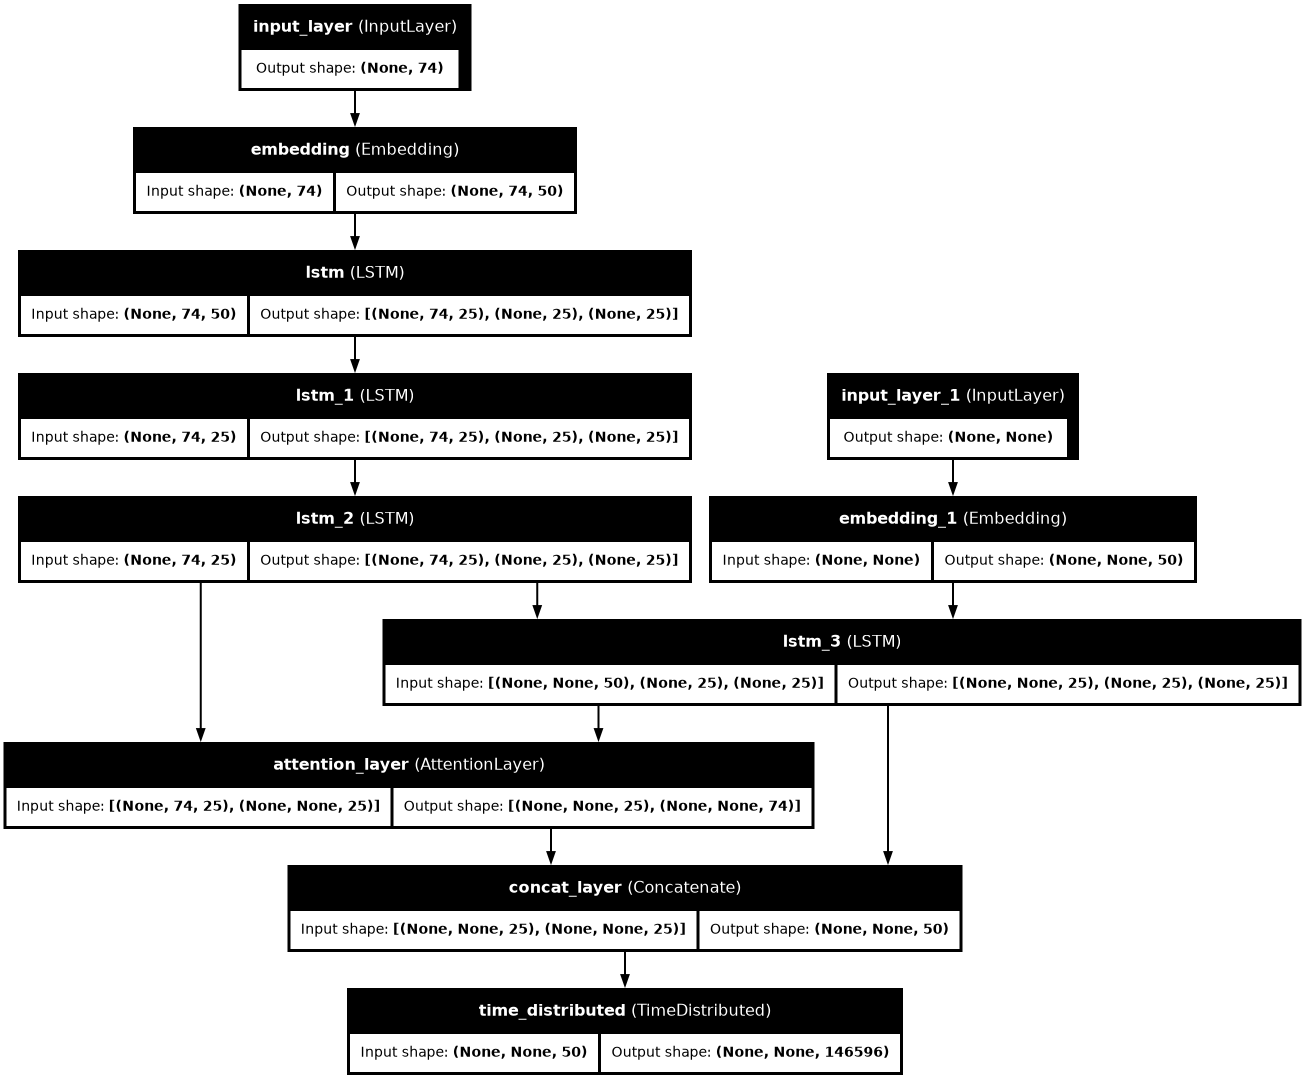

In [22]:
plot_model(model, to_file='./seq2seq_encoder_decoder.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=72)

In [23]:
# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Training the model with Early Stopping callback on val_loss.
history = model.fit(
    [x_train_pad, y_train_pad[:, :-1]],
    y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)[:, 1:],
    epochs=15,
    callbacks=[callback],
    batch_size=512, 
    validation_data=([x_valid_pad, y_valid_pad[:, :-1]], y_valid_pad.reshape(y_valid_pad.shape[0], y_valid_pad.shape[1], 1)[:, 1:])
)

Epoch 1/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 268s 457ms/step - loss: 9.4357 - val_loss: 6.9955
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 255s 455ms/step - loss: 6.9985 - val_loss: 6.7654
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 255s 454ms/step - loss: 6.8095 - val_loss: 6.6829
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 254s 452ms/step - loss: 6.7356 - val_loss: 6.6442
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 255s 455ms/step - loss: 6.7009 - val_loss: 6.6242
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 256s 456ms/step - loss: 6.6778 - val_loss: 6.6020
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 255s 455ms/step - loss: 6.6618 - val_loss: 6.5899
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 255s 454ms/step - loss: 6.6481 - val_loss: 6.5794
Epoch 9/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 255s 454ms/step - loss: 6.6395 - val_loss: 6.5679
Epoch 10/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 256s 456ms/step - loss: 6.6273 - val_loss: 6.5565
Epoch 11/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 255s 455ms/step - loss: 6.6231 - val_loss: 6.5508
Epoch 12

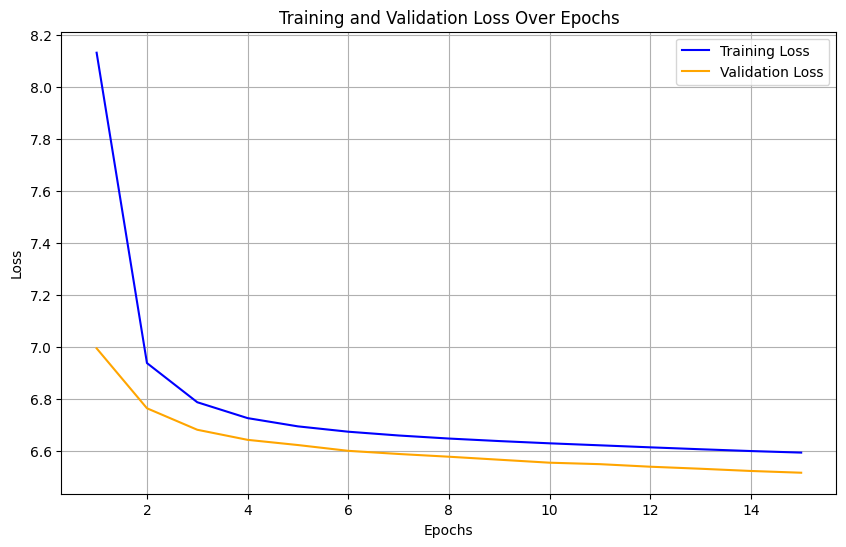

In [24]:
# Extract loss and val_loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')

# Adding titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png', 
            dpi=300, 
            bbox_inches='tight')
# Show the plot
plt.show()

In [25]:
# Save the trained model
model.save('Seq2Seq_CNN.h5')  # Save in HDF5 format

## V. Inference Stage: Making Predictions!

In [26]:
#Encoder inference model with trained inputs and outputs.
encoder_model = Model(inputs=encoder_input, outputs=[encoder_output, a_enc, c_enc])

#Initialising state vectors for decoder.
decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_len_news, latent_dim))

#Decoder inference model
decoder_out, decoder_a, decoder_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat)
decoder_model = Model([decoder_input]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_a, decoder_c])

In [27]:
#Function to generate output summaries.
def decoded_sequence(input_seq):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_seq, verbose=0) #Collecting output from encoder inference model.
    #Initialise input to decoder neuron with START token. Thereafter output token predicted by each neuron will be used as input for the subsequent.
    #Single elt matrix used for maintaining dimensions.
    next_input = np.zeros((1,1))
    next_input[0,0] = headline_tokenizer.word_index['start']
    output_seq = ''
    #Stopping condition to terminate loop when one summary is generated.
    stop = False
    while not stop:
        #Output from decoder inference model, with output states of encoder used for initialisation.
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c], verbose=0)
        #Get index of output token from y(t) of decoder.
        output_idx = np.argmax(decoded_out[0, -1, :])
        #If output index corresponds to END token, summary is terminated without of course adding the END token itself.
        if output_idx == headline_tokenizer.word_index['end']: 
            stop = True
        elif output_idx>0 and output_idx != headline_tokenizer.word_index['start'] :
            output_token = headline_tokenizer.index_word[output_idx] #Generate the token from index.
            output_seq = output_seq + ' ' + output_token #Append to summary
        
        #Pass the current output index as input to next neuron.
        next_input[0,0] = output_idx
        #Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_seq 

In [28]:
# Initialize a list to store the ROUGE scores
rouge_scores = []

# Define the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Generate predictions and calculate ROUGE scores
predicted = []
for i in range(len(X_test)):  # Loop through the entire test set
    predicted_headline = decoded_sequence(x_test_pad[i].reshape(1, max_len_news))
    predicted.append(predicted_headline)  # Store the predicted output

    # Calculate ROUGE scores
    scores = scorer.score(y_test.iloc[i], predicted_headline)
    rouge_scores.append(scores)

# Convert scores to numpy arrays for easier handling
rouge1_scores = np.array([score['rouge1'].fmeasure for score in rouge_scores])
rouge2_scores = np.array([score['rouge2'].fmeasure for score in rouge_scores])
rougeL_scores = np.array([score['rougeL'].fmeasure for score in rouge_scores])

# Calculate average ROUGE scores
average_rouge1 = np.mean(rouge1_scores)
average_rouge2 = np.mean(rouge2_scores)
average_rougeL = np.mean(rougeL_scores)

# Display average ROUGE scores
print(f'Average ROUGE-1: {average_rouge1:.4f}')
print(f'Average ROUGE-2: {average_rouge2:.4f}')
print(f'Average ROUGE-L: {average_rougeL:.4f}')

Average ROUGE-1: 0.0269
Average ROUGE-2: 0.0001
Average ROUGE-L: 0.0255


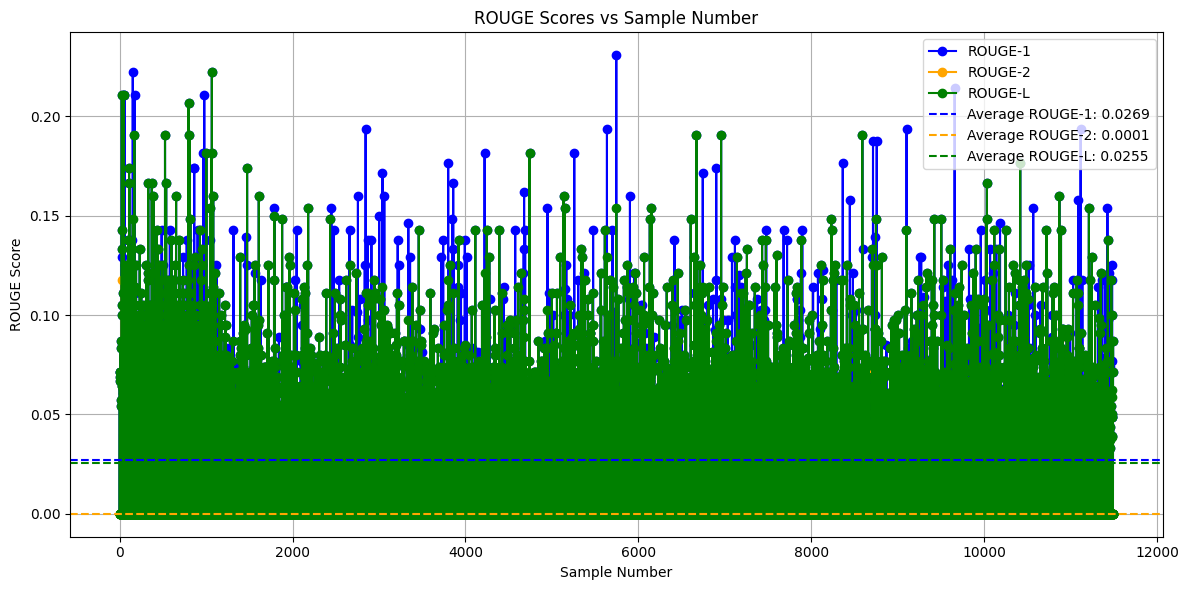

In [29]:
# Plotting ROUGE scores
plt.figure(figsize=(12, 6))

# Sample numbers (1, 2, ..., len(X_test))
sample_numbers = np.arange(1, len(X_test) + 1)

# Plot each ROUGE score
plt.plot(sample_numbers, rouge1_scores, marker='o', label='ROUGE-1', color='blue')
plt.plot(sample_numbers, rouge2_scores, marker='o', label='ROUGE-2', color='orange')
plt.plot(sample_numbers, rougeL_scores, marker='o', label='ROUGE-L', color='green')

# Mark the averages with horizontal lines
plt.axhline(y=average_rouge1, color='blue', linestyle='--', label=f'Average ROUGE-1: {average_rouge1:.4f}')
plt.axhline(y=average_rouge2, color='orange', linestyle='--', label=f'Average ROUGE-2: {average_rouge2:.4f}')
plt.axhline(y=average_rougeL, color='green', linestyle='--', label=f'Average ROUGE-L: {average_rougeL:.4f}')

# Add titles and labels
plt.title('ROUGE Scores vs Sample Number')
plt.xlabel('Sample Number')
plt.ylabel('ROUGE Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./rougue_cnn.png')
# Show the plot
plt.show()

# Part 2: Applying the Model to New Data (20 Marks)

In [30]:
# Load the dataset without specifying features
dataset = load_dataset(
    "jordiclive/wikipedia-summary-dataset",
    data_files="df_withoutDescription.parquet",
    split="train[:10000]"
)

# Convert to pandas DataFrame
df = pd.DataFrame.from_dict(dataset)

# Keep only the specified columns and rename them
df = df[['full_text', 'summary']].rename(columns={'full_text': 'text', 'summary': 'summary'})

# Save the DataFrame to a CSV file
df.to_csv('wiki_ds.csv', index=False)

README.md:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


df_withoutDescription.parquet:   0%|          | 0.00/6.77G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [31]:
df.head()

,text,summary
0,Actresses (Catalan: Actrius) is a 1997 Catalan...,Actresses (Catalan: Actrius) is a 1997 Catalan...
1,"Alien primarily refers to:\n* Alien (law), a p...","Alien primarily refers to:\n* Alien (law), a p..."
2,"In law, an answer was originally a solemn asse...","In law, an answer was originally a solemn asse..."
3,Abel is a Biblical figure in the Book of Genes...,Abel is a Biblical figure in the Book of Genes...
4,This article is about the demographic features...,This article is about the demographic features...


In [32]:
# Split into inputs and outputs
X_test = df['text']
y_test = df['summary']

# Initialize Keras tokenizer for news text
x_test_seq = news_tokenizer.texts_to_sequences(X_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len_news, padding='post')

# Initialize Keras tokenizer for summaries
y_test_seq = headline_tokenizer.texts_to_sequences(y_test)
y_test_pad = pad_sequences(y_test_seq, maxlen=max_len_headline, padding='post')

In [33]:
# Initialize a list to store the ROUGE scores
rouge_scores = []

# Define the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Generate predictions and calculate ROUGE scores
predicted = []
for i in range(len(X_test)):  # Loop through the entire test set
    predicted_headline = decoded_sequence(x_test_pad[i].reshape(1, max_len_news))
    predicted.append(predicted_headline)  # Store the predicted output

    # Calculate ROUGE scores
    scores = scorer.score(y_test.iloc[i], predicted_headline)
    rouge_scores.append(scores)

# Convert scores to numpy arrays for easier handling
rouge1_scores = np.array([score['rouge1'].fmeasure for score in rouge_scores])
rouge2_scores = np.array([score['rouge2'].fmeasure for score in rouge_scores])
rougeL_scores = np.array([score['rougeL'].fmeasure for score in rouge_scores])

# Calculate average ROUGE scores
average_rouge1 = np.mean(rouge1_scores)
average_rouge2 = np.mean(rouge2_scores)
average_rougeL = np.mean(rougeL_scores)

# Display average ROUGE scores
print(f'Average ROUGE-1: {average_rouge1:.4f}')
print(f'Average ROUGE-2: {average_rouge2:.4f}')
print(f'Average ROUGE-L: {average_rougeL:.4f}')

Average ROUGE-1: 0.0126
Average ROUGE-2: 0.0000
Average ROUGE-L: 0.0125


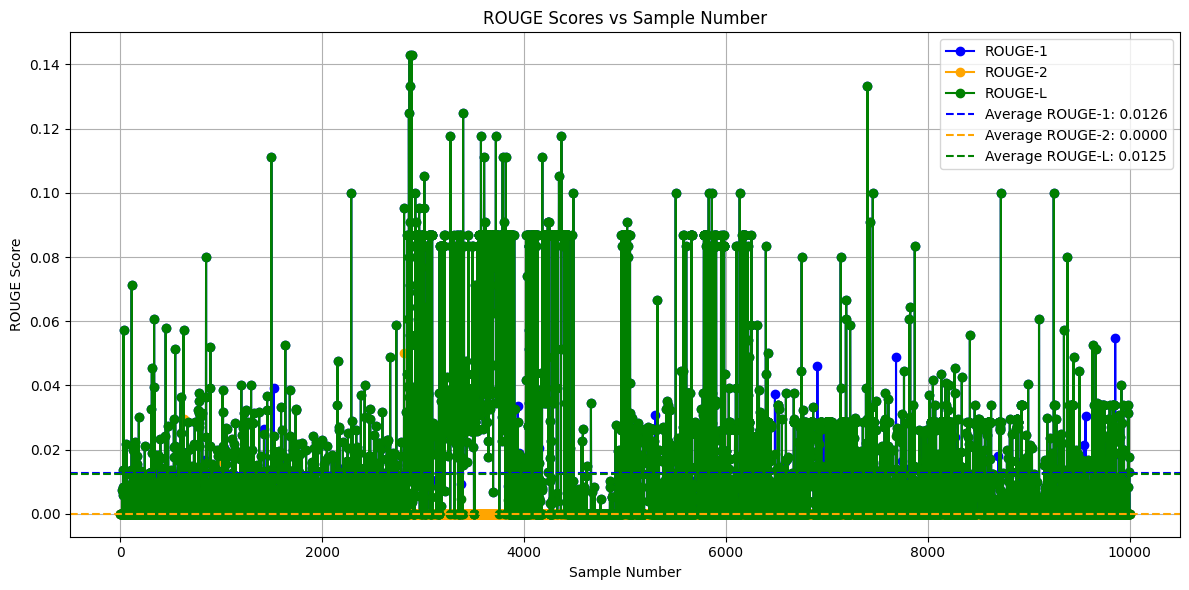

In [34]:
# Plotting ROUGE scores
plt.figure(figsize=(12, 6))

# Sample numbers (1, 2, ..., len(X_test))
sample_numbers = np.arange(1, len(X_test) + 1)

# Plot each ROUGE score
plt.plot(sample_numbers, rouge1_scores, marker='o', label='ROUGE-1', color='blue')
plt.plot(sample_numbers, rouge2_scores, marker='o', label='ROUGE-2', color='orange')
plt.plot(sample_numbers, rougeL_scores, marker='o', label='ROUGE-L', color='green')

# Mark the averages with horizontal lines
plt.axhline(y=average_rouge1, color='blue', linestyle='--', label=f'Average ROUGE-1: {average_rouge1:.4f}')
plt.axhline(y=average_rouge2, color='orange', linestyle='--', label=f'Average ROUGE-2: {average_rouge2:.4f}')
plt.axhline(y=average_rougeL, color='green', linestyle='--', label=f'Average ROUGE-L: {average_rougeL:.4f}')

# Add titles and labels
plt.title('ROUGE Scores vs Sample Number')
plt.xlabel('Sample Number')
plt.ylabel('ROUGE Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./rougue_wiki.png')
# Show the plot
plt.show()